In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from PIL import Image


USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"

TRAIN = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Use CUDA


In [15]:
!wget https://data.deepai.org/PascalVOC2012.zip
!unzip PascalVOC2012.zip
!mv voc2012 VOCdevkit

In [20]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
MULTICLASS = True
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 21


In [21]:
from torchvision.datasets import VOCDetection
from torchvision import transforms

In [22]:
trainset_raw = VOCDetection(DATA_ROOT, VOC_YEAR, "train", download=False)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [24]:
sample_index = random.randint(0, len(trainset_raw) - 1)
image, target = trainset_raw[sample_index]

plt.imshow(image)
ax = plt.gca()

for obj in target['annotation']['object']:
    bbox = obj['bndbox']
    xmin, ymin, xmax, ymax = float(bbox['xmin']), float(bbox['ymin']), float(bbox['xmax']), float(bbox['ymax'])
    width = xmax - xmin
    height = ymax - ymin

    class_label = obj['name']

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 5, class_label, color='r')

plt.show()


In [25]:
class Scaler(object):
    def __init__(self, size):
        self._size = size
        self._padding = 0

    def set_padding(self, padding):
        self._padding = padding

    def __call__(self, image, boxes):
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]

        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape

        # Масштабирование изображения
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2

        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]

        if grayscale:
            result = result[:, :, 0]

        boxes[:, [0, 2]] = (boxes[:, [0, 2]] * scale) + offset_x
        boxes[:, [1, 3]] = (boxes[:, [1, 3]] * scale) + offset_y

        return result, boxes


def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask


In [26]:
import albumentations as A
class CustomAugmentation:
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Blur(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.RandomBrightnessContrast(p=0.2),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    def __call__(self, image, boxes, labels):
        augmented = self.transform(image=image, bboxes=boxes, labels=labels)
        return augmented

In [27]:
import torch
from torchvision.transforms import functional as F

class PascalVocDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root,
        year,
        image_size,
        download=False,
        train=False,
        train_fraction=0.8,
        augmentations=None,
        tokenizer=None,
        padding=0,
    ):
        self._dataset = VOCDetection(root, year, "trainval", download=download)
        self.tokenizer = tokenizer
        self._image_scaler = Scaler(image_size)

        self._image_size = np.array(image_size)
        self._padding = padding
    
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._augmenter = augmentations
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)
            ),
        ])

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)


    def __getitem__(self, idx):
        image, target = self._dataset[self._indices[idx]]

        # Проходим по всем объектам в аннотации и создаем список баундинг боксов
        boxes = []
        labels = []

        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            xmin, ymin, xmax, ymax = float(bbox['xmin']), float(bbox['ymin']), float(bbox['xmax']), float(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])

            # Получаем метку класса
            class_label = obj['name']

            # Преобразуем строковую метку в числовой формат (по желанию)
            labels.append(LABELS.index(class_label))

        # Применяем аугментации, если они заданы
        if self._augmenter:
            augmented = self._augmenter(image=np.array(image), boxes=boxes, labels=labels)
            image = augmented['image']
            boxes = np.array(augmented['bboxes'], dtype=np.float32)
            labels = np.array(augmented['labels'], dtype=np.int64)

        image, boxes = self._image_scaler(np.array(image), np.array(boxes))

        image = self._transform(image)
    
        if self.tokenizer is not None:
            seqs = self.tokenizer(labels, boxes)
            seqs = torch.LongTensor(seqs)
            return image, seqs, boxes, labels

        return image, boxes, labels



In [28]:
train_ds = PascalVocDataset(
    DATA_ROOT,
    VOC_YEAR,
    image_size=(300,300),
    train=True,
    augmentations=CustomAugmentation()
)

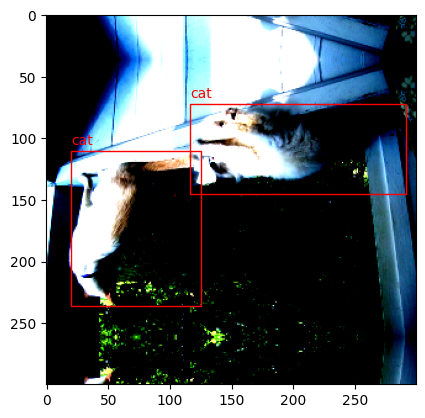

In [29]:
sample_index = random.randint(0, len(train_ds) - 1)
sample = train_ds[sample_index]
image, target, label = sample

plt.imshow(image.permute(1, 2, 0))
ax = plt.gca()

for ann, lab in zip(target, label):
    xmin, ymin, xmax, ymax = ann.tolist()
    width = xmax - xmin
    height = ymax - ymin

    class_label = LABELS[lab]

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 5, class_label, color='r')

plt.show()

In [30]:
valid_ds = PascalVocDataset(
    DATA_ROOT,
    VOC_YEAR,
    image_size=(300,300),
    train=False,
)

In [31]:
sample_index = random.randint(0, len(valid_ds) - 1)
sample = valid_ds[sample_index]
image, target, label = sample

plt.imshow(image.permute(1, 2, 0))
ax = plt.gca()

for ann, lab in zip(target, label):
    xmin, ymin, xmax, ymax = ann.tolist()
    width = xmax - xmin
    height = ymax - ymin

    class_label = LABELS[lab]

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 5, class_label, color='r')

plt.show()

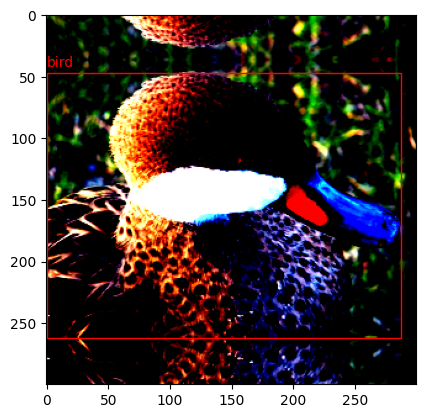

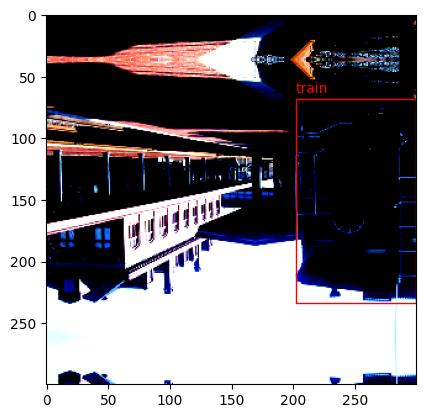

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_images_with_boxes(dataset, num_images=5):
    for _ in range(num_images):
        idx = random.randint(0, len(dataset) - 1)

        sample = dataset[idx]
        image, target, label = sample

        fig, ax = plt.subplots(1)
        ax.imshow(image.permute(1, 2, 0))

        for ann, lab in zip(target,label):
            xmin, ymin, xmax, ymax = ann.tolist()
            width = xmax - xmin
            height = ymax - ymin
            class_label = LABELS[lab]

            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            ax.text(xmin, ymin - 5, class_label, color='r')

        plt.show()


show_images_with_boxes(train_ds)


In [33]:
import gc
import os
import cv2
import math
import random
from glob import glob
import numpy as np
import pandas as pd
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
import xml.etree.ElementTree as ET
from sklearn.model_selection import StratifiedGroupKFold

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import timm
from timm.models.layers import trunc_normal_

import transformers
from transformers import top_k_top_p_filtering
from transformers import get_linear_schedule_with_warmup


In [34]:
class CFG:

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_len = 500

    img_size = 384
    num_bins = img_size
    
    batch_size = 16
    epochs = 10
    
    model_name = 'deit3_small_patch16_384_in21ft1k'
    num_patches = 576
    lr = 1e-4
    weight_decay = 1e-4

    generation_steps = 101

In [35]:
class Tokenizer:
    def __init__(
        self,
        num_classes: int,
        num_bins: int,
        width: int,
        height: int,
        max_len=500
    ):
        self.num_classes = num_classes
        self.num_bins = num_bins
        self.width = width
        self.height = height
        self.max_len = max_len

        self.BOS_code = num_classes + num_bins
        self.EOS_code = self.BOS_code + 1
        self.PAD_code = self.EOS_code + 1

        self.vocab_size = num_classes + num_bins + 3

    def quantize(self, x: np.array):
        """
        x is a real number in [0, 1]
        """
        return (x * (self.num_bins - 1)).astype('int')
    
    def dequantize(self, x: np.array):
        """
        x is an integer between [0, num_bins-1]
        """
        return x.astype('float32') / (self.num_bins - 1)

    def __call__(self, labels: list, bboxes: list, shuffle=True):
        assert len(labels) == len(bboxes), "labels and bboxes must have the same length"
        bboxes = np.array(bboxes)
        labels = np.array(labels)
        labels += self.num_bins
        labels = labels.astype('int')[:self.max_len]

        bboxes[:, 0] = bboxes[:, 0] / self.width
        bboxes[:, 2] = bboxes[:, 2] / self.width
        bboxes[:, 1] = bboxes[:, 1] / self.height
        bboxes[:, 3] = bboxes[:, 3] / self.height

        bboxes = self.quantize(bboxes)[:self.max_len]

        if shuffle:
            rand_idxs = np.arange(0, len(bboxes))
            np.random.shuffle(rand_idxs)
            labels = labels[rand_idxs]
            bboxes = bboxes[rand_idxs]

        tokenized = [self.BOS_code]
        for label, bbox in zip(labels, bboxes):
            tokens = list(bbox)
            tokens.append(label)

            tokenized.extend(list(map(int, tokens)))
        tokenized.append(self.EOS_code)

        return tokenized    
    
    def decode(self, tokens: torch.tensor):
        """
        toekns: torch.LongTensor with shape [L]
        """
        mask = tokens != self.PAD_code
        tokens = tokens[mask]
        tokens = tokens[1:-1]
        assert len(tokens) % 5 == 0, "invalid tokens"

        labels = []
        bboxes = []
        for i in range(4, len(tokens)+1, 5):
            label = tokens[i]
            bbox = tokens[i-4: i]
            labels.append(int(label))
            bboxes.append([int(item) for item in bbox])
        labels = np.array(labels) - self.num_bins
        bboxes = np.array(bboxes)
        bboxes = self.dequantize(bboxes)
        
        bboxes[:, 0] = bboxes[:, 0] * self.width
        bboxes[:, 2] = bboxes[:, 2] * self.width
        bboxes[:, 1] = bboxes[:, 1] * self.height
        bboxes[:, 3] = bboxes[:, 3] * self.height
        
        return labels, bboxes

In [36]:
tokenizer = Tokenizer(
    num_classes=len(LABELS),
    num_bins=CFG.num_bins,
    width=CFG.img_size,
    height=CFG.img_size,
    max_len=CFG.max_len,
)

CFG.pad_idx = tokenizer.PAD_code

In [37]:
def collate_fn(batch, max_len, pad_idx):
    """
    if max_len:
        the sequences will all be padded to that length
    """
    image_batch, seq_batch = [], []
    boxes_batch, labels_batch = [], []
    for image, seq, boxes, labels in batch:
        image_batch.append(image)
        seq_batch.append(seq)
        boxes_batch.append(boxes)
        labels_batch.append(labels)

    seq_batch = pad_sequence(
        seq_batch, padding_value=pad_idx, batch_first=True
    )
    if max_len:
        max_len = max_len if max_len > seq_batch.size(1) else seq_batch.size(1)
        pad = torch.ones(seq_batch.size(0), max_len - seq_batch.size(1)).fill_(pad_idx).long()
        seq_batch = torch.cat([seq_batch, pad], dim=1)


    image_batch = torch.stack(image_batch)
    return image_batch, seq_batch, boxes_batch, labels_batch

In [38]:
def get_loaders(tokenizer, img_size, batch_size, max_len, pad_idx, num_workers=2):

    train_ds = PascalVocDataset(
        DATA_ROOT,
        VOC_YEAR,
        image_size=(img_size,img_size),
        train=True,
        augmentations=CustomAugmentation(),
        tokenizer=tokenizer,
    )


    trainloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_fn, max_len=max_len, pad_idx=pad_idx),
        num_workers=num_workers,
        pin_memory=True,
    )

    
    valid_ds = PascalVocDataset(
        DATA_ROOT,
        VOC_YEAR,
        image_size=(img_size,img_size),
        train=False,
        tokenizer=tokenizer,
    )

    validloader = torch.utils.data.DataLoader(
        valid_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(collate_fn, max_len=max_len, pad_idx=pad_idx),
        num_workers=1,
        drop_last=True,
        pin_memory=True,
    )

    return trainloader, validloader

In [39]:
train_loader, valid_loader = get_loaders(
    tokenizer,
    CFG.img_size,
    CFG.batch_size,
    CFG.max_len,
    tokenizer.PAD_code
)

In [40]:
class Encoder(nn.Module):
    def __init__(self, model_name='deit3_small_patch16_384_in21ft1k', pretrained=False, out_dim=256):
        super().__init__()
        self.model = timm.create_model(
            model_name, num_classes=0, global_pool='', pretrained=pretrained)
        self.bottleneck = nn.AdaptiveAvgPool1d(out_dim)

    def forward(self, x):
        features = self.model(x)
        return self.bottleneck(features[:, 1:])

In [41]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, encoder_length, dim, num_heads, num_layers):
        super().__init__()
        self.dim = dim
        
        self.embedding = nn.Embedding(vocab_size, dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, CFG.max_len-1, dim) * .02)
        self.decoder_pos_drop = nn.Dropout(p=0.05)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim, nhead=num_heads)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output = nn.Linear(dim, vocab_size)
        
        
        self.encoder_pos_embed = nn.Parameter(torch.randn(1, encoder_length, dim) * .02)
        self.encoder_pos_drop = nn.Dropout(p=0.05)
        
        self.init_weights()
        
    def init_weights(self):
        for name, p in self.named_parameters():
            if 'encoder_pos_embed' in name or 'decoder_pos_embed' in name: 
                print("skipping pos_embed...")
                continue
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
        trunc_normal_(self.encoder_pos_embed, std=.02)
        trunc_normal_(self.decoder_pos_embed, std=.02)
        
    
    def forward(self, encoder_out, tgt):
        """
        encoder_out: shape(N, L, D)
        tgt: shape(N, L)
        """
        
        tgt_mask, tgt_padding_mask = create_mask(tgt)
        tgt_embedding = self.embedding(tgt)
        tgt_embedding = self.decoder_pos_drop(
            tgt_embedding + self.decoder_pos_embed
        )
        
        encoder_out = self.encoder_pos_drop(
            encoder_out + self.encoder_pos_embed
        )
        
        encoder_out = encoder_out.transpose(0, 1)
        tgt_embedding = tgt_embedding.transpose(0, 1)
        
        preds = self.decoder(memory=encoder_out, 
                             tgt=tgt_embedding,
                             tgt_mask=tgt_mask, 
                             tgt_key_padding_mask=tgt_padding_mask)
        
        preds = preds.transpose(0, 1)
        return self.output(preds)
    
    def predict(self, encoder_out, tgt):
        length = tgt.size(1)
        padding = torch.ones(tgt.size(0), CFG.max_len-length-1).fill_(CFG.pad_idx).long().to(tgt.device)
        tgt = torch.cat([tgt, padding], dim=1)
        tgt_mask, tgt_padding_mask = create_mask(tgt)
        # is it necessary to multiply it by math.sqrt(d) ?
        tgt_embedding = self.embedding(tgt)
        tgt_embedding = self.decoder_pos_drop(
            tgt_embedding + self.decoder_pos_embed
        )
        
        encoder_out = self.encoder_pos_drop(
            encoder_out + self.encoder_pos_embed
        )
        
        encoder_out = encoder_out.transpose(0, 1)
        tgt_embedding = tgt_embedding.transpose(0, 1)
        
        preds = self.decoder(memory=encoder_out, 
                             tgt=tgt_embedding,
                             tgt_mask=tgt_mask, 
                             tgt_key_padding_mask=tgt_padding_mask)
        
        preds = preds.transpose(0, 1)
        return self.output(preds)[:, length-1, :]

In [42]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, image, tgt):
        encoder_out = self.encoder(image)
        preds = self.decoder(encoder_out, tgt)
        return preds
    def predict(self, image, tgt):
        encoder_out = self.encoder(image)
        preds = self.decoder.predict(encoder_out, tgt)
        return preds

In [43]:
encoder = Encoder(model_name=CFG.model_name, pretrained=True, out_dim=256)
decoder = Decoder(vocab_size=tokenizer.vocab_size,
                  encoder_length=CFG.num_patches, dim=256, num_heads=8, num_layers=6)
model = EncoderDecoder(encoder, decoder)
model.to(CFG.device);

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name deit3_small_patch16_384_in21ft1k to current deit3_small_patch16_384.fb_in22k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

skipping pos_embed...
skipping pos_embed...


In [44]:
from numba import jit
@jit(nopython=True)
def calculate_iou(gt, pr, form='coco') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.
       The mean average precision at different intersection over union (IoU) thresholds.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [96]:
iou_thresholds = [0.5]

class EvalMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.image_precision = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, gt_boxes, pred_boxes, n=1):       
        """ pred_boxes : need to be sorted."""
        self.image_precision = 0
        try:
            if not (None in gt_boxes or None in pred_boxes):
                self.image_precision = calculate_image_precision(
                    pred_boxes,
                    gt_boxes,
                    thresholds=iou_thresholds,
                    form='coco'
                )
        except:
            self.image_precision = 0

        self.count += n
        self.sum += self.image_precision * n
        self.avg = self.sum / self.count

In [46]:
def generate(model, x, tokenizer, max_len=50, top_k=0, top_p=1):
    x = x.to(CFG.device)
    batch_preds = torch.ones(x.size(0), 1).fill_(tokenizer.BOS_code).long().to(CFG.device)
    confs = []
    
    if top_k != 0 or top_p != 1:
        sample = lambda preds: torch.softmax(preds, dim=-1).multinomial(num_samples=1).view(-1, 1)
    else:
        sample = lambda preds: torch.softmax(preds, dim=-1).argmax(dim=-1).view(-1, 1)
        
    with torch.no_grad():
        for i in range(max_len):
            preds = model.predict(x, batch_preds)
            ## If top_k and top_p are set to default, the following line does nothing!
            preds = top_k_top_p_filtering(preds, top_k=top_k, top_p=top_p)
            if i % 4 == 0:
                confs_ = torch.softmax(preds, dim=-1).sort(axis=-1, descending=True)[0][:, 0].cpu()
                confs.append(confs_)
            preds = sample(preds)
            batch_preds = torch.cat([batch_preds, preds], dim=1)
    
    return batch_preds.cpu(), confs

In [47]:
def postprocess(batch_preds, batch_confs, tokenizer):
    EOS_idxs = (batch_preds == tokenizer.EOS_code).float().argmax(dim=-1)
    ## sanity check
    invalid_idxs = ((EOS_idxs - 1) % 5 != 0).nonzero().view(-1)
    EOS_idxs[invalid_idxs] = 0
    
    all_bboxes = []
    all_labels = []
    all_confs = []
    for i, EOS_idx in enumerate(EOS_idxs.tolist()):
        if EOS_idx == 0:
            all_bboxes.append(None)
            all_labels.append(None)
            all_confs.append(None)
            continue
        labels, bboxes = tokenizer.decode(batch_preds[i, :EOS_idx+1])
        confs = [round(batch_confs[j][i].item(), 3) for j in range(len(bboxes))]
        
        all_bboxes.append(bboxes)
        all_labels.append(labels)
        all_confs.append(confs)
        
    return all_bboxes, all_labels, all_confs

In [48]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=CFG.device))
            == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(tgt):
    """
    tgt: shape(N, L)
    """
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    tgt_padding_mask = (tgt == CFG.pad_idx)

    return tgt_mask, tgt_padding_mask


class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0]*3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [49]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, criterion, logger=None):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    
    for x, y, _, _ in tqdm_object:
        x, y = x.to(CFG.device, non_blocking=True), y.to(CFG.device, non_blocking=True)
        
        y_input = y[:, :-1]
        y_expected = y[:, 1:]
        

        preds = model(x, y_input)
        loss = criterion(preds.reshape(-1, preds.shape[-1]), y_expected.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        loss_meter.update(loss.item(), x.size(0))
        
        lr = get_lr(optimizer)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=f"{lr:.6f}")
        if logger is not None:
            logger.log({"train_step_loss": loss_meter.avg, 'lr': lr})
    
    return loss_meter.avg

In [98]:
def valid_epoch(model, valid_loader, criterion):
    model.eval()
    loss_meter = AvgMeter()
    eval_scores = EvalMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    
    with torch.no_grad():
        for x, y, boxes, labels in tqdm_object:
            x, y = x.to(CFG.device, non_blocking=True), y.to(CFG.device, non_blocking=True)

            y_input = y[:, :-1]
            y_expected = y[:, 1:]

            preds = model(x, y_input)
            
            loss = criterion(preds.reshape(-1, preds.shape[-1]), y_expected.reshape(-1))
            loss_meter.update(loss.item(), x.size(0))

            try:
                batch_preds, batch_confs = generate(
                    model,
                    x,
                    tokenizer,
                    max_len=CFG.generation_steps,
                    top_k=0,
                    top_p=1
                )
                bboxes_preds, labels_preds, confs_preds = postprocess(
                    batch_preds,
                    batch_confs,
                    tokenizer
                )
            except:
                continue
            for pred, gt in zip(bboxes_preds, boxes):
                eval_scores.update(gt_boxes=gt, pred_boxes=pred)
            
            
    return loss_meter.avg, eval_scores.avg

In [92]:
def train_eval(
    model, 
    train_loader,
    valid_loader,
    criterion, 
    optimizer, 
    lr_scheduler,
    step,
    logger
):
    if logger:
        logger.config = {
          "learning_rate": CFG.lr,
          "epochs": CFG.epochs,
          "batch_size": CFG.batch_size
        }

    best_loss = float('inf')
    
    for epoch in range(CFG.epochs):
        print(f"Epoch {epoch + 1}")
        if logger is not None:
            logger.log({"Epoch": epoch + 1})
        
        train_loss = train_epoch(model, train_loader, optimizer, 
                                 lr_scheduler if step == 'batch' else None, 
                                 criterion, logger=logger)
        
        if logger is not None:
            logger.log({
                'train_loss': train_loss,
            })

        if step == 'epoch':
            pass

        if (epoch+1) % (CFG.epochs) == 0:
            valid_loss, metric_map = valid_epoch(model, valid_loader, criterion)
            print(f"Valid loss: {valid_loss:.3f} Valid mAP: {metric_map:.3f}")
        
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), 'best_valid_loss.pth')
                print("Saved Best Model")
        
            if logger is not None:
                logger.log({
                    'valid_loss': valid_loss,
                    'valid_map': metric_map,
                })
                logger.save('best_valid_loss.pth')


In [52]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [91]:
wandb.init(project="DeiT", name="train pascal-voc")

In [93]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

num_training_steps = CFG.epochs * (len(train_loader.dataset) // CFG.batch_size)
num_warmup_steps = int(0.05 * num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(optimizer,
                                               num_training_steps=num_training_steps,
                                               num_warmup_steps=num_warmup_steps)
criterion = nn.CrossEntropyLoss(ignore_index=CFG.pad_idx)

train_eval(model,
           train_loader,
           valid_loader,
           criterion,
           optimizer,
           lr_scheduler=lr_scheduler,
           step='batch',
           logger=wandb)

Epoch 1


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000095, train_loss=4.28]


Epoch 2


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000084, train_loss=4.2] 


Epoch 3


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000074, train_loss=4.09]


Epoch 4


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000063, train_loss=3.98]


Epoch 5


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000053, train_loss=3.88]


Epoch 6


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000042, train_loss=3.81]


Epoch 7


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000032, train_loss=3.74]


Epoch 8


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000021, train_loss=3.7] 


Epoch 9


100%|██████████| 577/577 [05:28<00:00,  1.76it/s, lr=0.000011, train_loss=3.65]


Epoch 10


  0%|          | 0/144 [00:15<?, ?it/s]


Valid loss: 3.536 Valid mAP: 0.407
Saved Best Model


In [99]:
valid_loss, metric_map = valid_epoch(model, valid_loader, criterion)

  0%|          | 0/144 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 144/144 [36:41<00:00, 15.29s/it]


In [100]:
valid_loss, metric_map

(3.7112711485889225, 0.46550104058890657)

### Посмотреть логи обучения тут -> [ссылка](https://wandb.ai/rbeketov/DeiT/runs/z407z3pa?workspace=user-)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xMDTrHIK_gw3vLsmLZc8N2vCXNGouWQS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xMDTrHIK_gw3vLsmLZc8N2vCXNGouWQS" -O seminar_objdet_retina_oi5_ball.zip && rm -rf /tmp/cookies.txt

!unzip seminar_objdet_retina_oi5_ball.zip -d seminar_objdet_retina_oi5_ball

In [106]:
import json

In [107]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None):
        self.transforms = transforms

        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path + i:j for i,j in self.data_dict.items()}

        self.imgs = list(self.data_dict.keys())

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        h, w = image.shape[:2]
#         img = Image.open(img_path).convert("RGB")
#         w, h = img.size

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = np.asarray(boxes)  # N x 4
        annot = np.zeros((len(boxes), 1))  # N x 1
        annot = np.concatenate((boxes, annot), axis=1)  # N x 5

        sample = {'img': image, 'annot': annot}
        
        if self.transforms:
            sample = self.transforms(sample)

        return sample

In [108]:
train_dataset = DetectionDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    add_path = './seminar_objdet_retina_oi5_ball/'
)
#train_sampler = AspectRatioBasedSampler(train_dataset, batch_size=4, drop_last=False) # deepdive
#train_dataloader = DataLoader(train_dataset, num_workers=8, collate_fn=collater, batch_sampler=train_sampler)

val_dataset = DetectionDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
    add_path = './seminar_objdet_retina_oi5_ball/'
)
#val_sampler = AspectRatioBasedSampler(val_dataset, batch_size=4, drop_last=False)
#val_dataloader = DataLoader(val_dataset, num_workers=8, collate_fn=collater, batch_sampler=val_sampler)

In [109]:
train_dataset[0]['img'].shape, train_dataset[0]['annot'].shape

((403, 640, 3), (6, 5))

In [110]:
train_dataset[1]['annot'][0]

array([455.542582, 503.04    , 605.897516, 652.16    ,   0.      ])

In [111]:
LABELS = ["Ball", "NotBall"]
MULTICLASS = False
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


In [112]:
tokenizer = Tokenizer(
    num_classes=len(LABELS),
    num_bins=CFG.num_bins,
    width=CFG.img_size,
    height=CFG.img_size,
    max_len=CFG.max_len,
)

CFG.pad_idx = tokenizer.PAD_code

In [113]:
import torch
from torchvision.transforms import functional as F

class BallDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_size,
        train=False,
        augmentations=None,
        tokenizer=None,
        padding=0,
    ):
        if train:
            self._dataset = DetectionDataset(
                data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                add_path = './seminar_objdet_retina_oi5_ball/'
            )
        else:
            self._dataset = DetectionDataset(
                data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                add_path = './seminar_objdet_retina_oi5_ball/'
            )
            
        self.tokenizer = tokenizer
        self._image_scaler = Scaler(image_size)

        self._image_size = np.array(image_size)
        self._padding = padding
    

        random.seed(0)
        self._indices = list(range(len(self._dataset)))

        self._augmenter = augmentations
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)
            ),
        ])

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)


    def __getitem__(self, idx):
        sample = self._dataset[self._indices[idx]]
        image, target = sample['img'], sample['annot']
        # Проходим по всем объектам в аннотации и создаем список баундинг боксов
        boxes = []
        labels = []

        for obj in target:
            bbox = obj[:4]
            xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
            boxes.append([xmin, ymin, xmax, ymax])

            # Получаем метку класса
            class_label = int(obj[4])


            labels.append(class_label)

        # Применяем аугментации, если они заданы
        if self._augmenter:
            augmented = self._augmenter(image=np.array(image), boxes=boxes, labels=labels)
            image = augmented['image']
            boxes = np.array(augmented['bboxes'], dtype=np.float32)
            labels = np.array(augmented['labels'], dtype=np.int64)

        image, boxes = self._image_scaler(np.array(image), np.array(boxes))

        image = self._transform(image)
    
        if self.tokenizer is not None:
            seqs = self.tokenizer(labels, boxes)
            seqs = torch.LongTensor(seqs)
            return image, seqs, boxes, labels

        return image, boxes, labels



In [114]:
train_ds = BallDataset(
    image_size=(300,300),
    train=True,
    augmentations=CustomAugmentation()
)

In [115]:
valid_ds = BallDataset(
    image_size=(300,300),
    train=False,
)

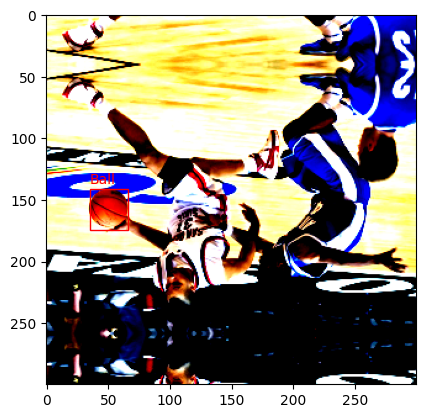

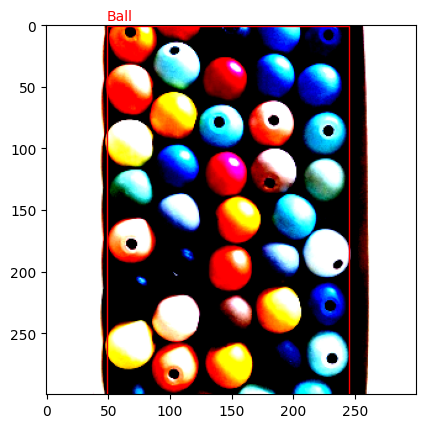

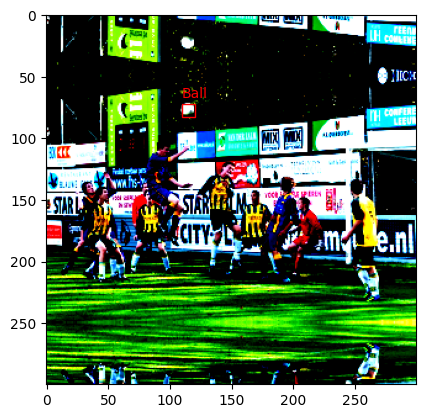

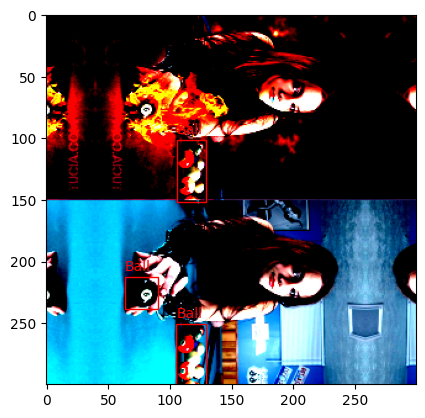

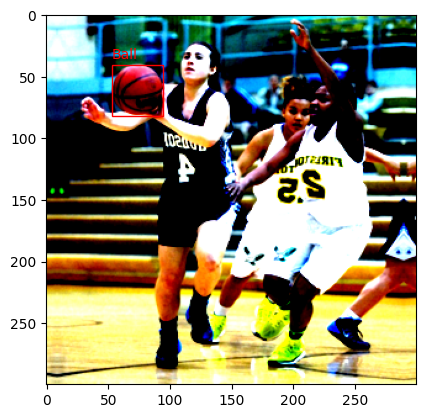

In [116]:
show_images_with_boxes(train_ds)

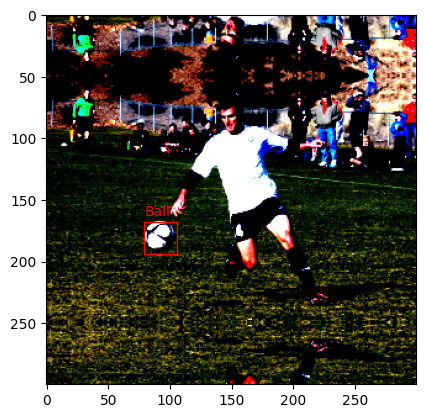

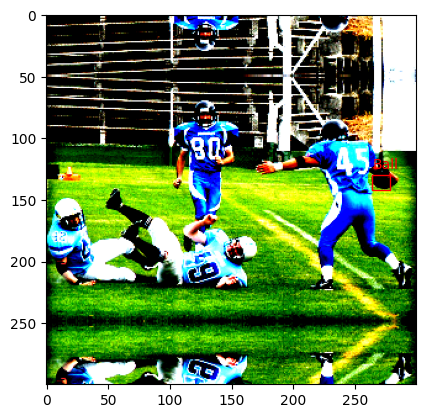

In [117]:
show_images_with_boxes(valid_ds)

In [118]:
def get_ball_loaders(tokenizer, img_size, batch_size, max_len, pad_idx, num_workers=2):
    train_ds = BallDataset(
        image_size=(img_size,img_size),
        train=True,
        augmentations=CustomAugmentation(),
        tokenizer=tokenizer,
    )


    trainloader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_fn, max_len=max_len, pad_idx=pad_idx),
        num_workers=num_workers,
        pin_memory=True,
    )

    
    valid_ds = BallDataset(
        image_size=(img_size,img_size),
        train=False,
        tokenizer=tokenizer,
    )

    validloader = torch.utils.data.DataLoader(
        valid_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(collate_fn, max_len=max_len, pad_idx=pad_idx),
        num_workers=1,
        drop_last=True,
        pin_memory=True,
    )

    return trainloader, validloader

In [40]:
# import wandb
# wandb.login()

True

In [119]:
wandb.init(project="DeiT", name="train ball")

In [42]:
# encoder = Encoder(model_name=CFG.model_name, pretrained=True, out_dim=256)
# decoder = Decoder(vocab_size=tokenizer.vocab_size,
#                   encoder_length=CFG.num_patches, dim=256, num_heads=8, num_layers=6)
# model = EncoderDecoder(encoder, decoder)
# model.load_state_dict(torch.load('/kaggle/input/hw6-deit/best_valid_loss.pth', map_location=CFG.device))

# model = EncoderDecoder(encoder, decoder)
# model.to(CFG.device)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name deit3_small_patch16_384_in21ft1k to current deit3_small_patch16_384.fb_in22k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

skipping pos_embed...
skipping pos_embed...


In [120]:
CFG.batch_size = 12

In [121]:
train_loader, valid_loader = get_ball_loaders(
     tokenizer,
     CFG.img_size,
     CFG.batch_size,
     CFG.max_len,
     tokenizer.PAD_code
)

In [143]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

num_training_steps = CFG.epochs * (len(train_loader.dataset) // CFG.batch_size)
num_warmup_steps = int(0.05 * num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(optimizer,
                                               num_training_steps=num_training_steps,
                                               num_warmup_steps=num_warmup_steps)
criterion = nn.CrossEntropyLoss(ignore_index=CFG.pad_idx)

train_eval(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    lr_scheduler=lr_scheduler,
    step='batch',
    logger=wandb,
)

Epoch 1


  0%|          | 0/240 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000095, train_loss=3.5] 


Epoch 2


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000084, train_loss=3.52]


Epoch 3


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000074, train_loss=3.47]


Epoch 4


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000063, train_loss=3.44]


Epoch 5


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000052, train_loss=3.39]


Epoch 6


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000042, train_loss=3.37]


Epoch 7


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000031, train_loss=3.32]


Epoch 8


100%|██████████| 240/240 [01:52<00:00,  2.14it/s, lr=0.000021, train_loss=3.28]


Epoch 9


100%|██████████| 240/240 [01:51<00:00,  2.16it/s, lr=0.000010, train_loss=3.26]


Epoch 10


100%|██████████| 18/18 [03:29<00:00, 11.62s/it]


Valid loss: 3.216 Valid mAP: 0.601
Saved Best Model


### Valid mAP: 0.601

### Логи [тут](https://wandb.ai/rbeketov/DeiT/runs/m8gu7j86?workspace=user-)

In [153]:
import torch
from torchvision.transforms import functional as F

class TestBallDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_size,
        train=False,
        augmentations=None,
        tokenizer=None,
        padding=0,
    ):
        if train:
            self._dataset = DetectionDataset(
                data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                add_path = './seminar_objdet_retina_oi5_ball/'
            )
        else:
            self._dataset = DetectionDataset(
                data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                add_path = './seminar_objdet_retina_oi5_ball/'
            )
            
        self.tokenizer = tokenizer
        self._image_scaler = Scaler(image_size)

        self._image_size = np.array(image_size)
        self._padding = padding
    

        random.seed(0)
        self._indices = list(range(len(self._dataset)))

        self._augmenter = augmentations
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)


    def __getitem__(self, idx):
        sample = self._dataset[self._indices[idx]]
        image, target = sample['img'], sample['annot']
        # Проходим по всем объектам в аннотации и создаем список баундинг боксов
        boxes = []
        labels = []

        for obj in target:
            bbox = obj[:4]
            xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
            boxes.append([xmin, ymin, xmax, ymax])

            # Получаем метку класса
            class_label = int(obj[4])


            labels.append(class_label)

        # Применяем аугментации, если они заданы
        if self._augmenter:
            augmented = self._augmenter(image=np.array(image), boxes=boxes, labels=labels)
            image = augmented['image']
            boxes = np.array(augmented['bboxes'], dtype=np.float32)
            labels = np.array(augmented['labels'], dtype=np.int64)

        image, boxes = self._image_scaler(np.array(image), np.array(boxes))

        image = self._transform(image)
    
        if self.tokenizer is not None:
            seqs = self.tokenizer(labels, boxes)
            seqs = torch.LongTensor(seqs)
            return image, seqs, boxes, labels

        return image, boxes, labels



In [154]:
test_ds = TestBallDataset(
            image_size=(CFG.img_size,CFG.img_size),
            train=False,
            tokenizer=tokenizer,
        )


testloader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=partial(collate_fn, max_len=CFG.max_len, pad_idx=CFG.pad_idx),
    num_workers=2,
    pin_memory=True,
)

In [155]:
model.eval()
with torch.no_grad():
    for x, y, _, _ in testloader:
        x, y = x.to(CFG.device, non_blocking=True), y.to(CFG.device, non_blocking=True)
        try:
            batch_preds, batch_confs = generate(
                model,
                x,
                tokenizer,
                max_len=CFG.generation_steps,
                top_k=0,
                top_p=1
            )
            bboxes_preds, labels_preds, confs_preds = postprocess(
                batch_preds,
                batch_confs,
                tokenizer
            )
        except:
            break
        break


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [156]:
len(x), len(bboxes_preds), len(labels_preds)

(12, 12, 12)

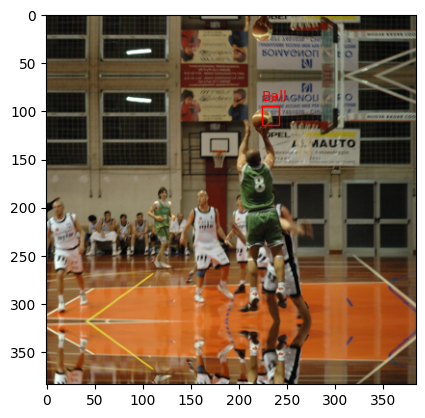

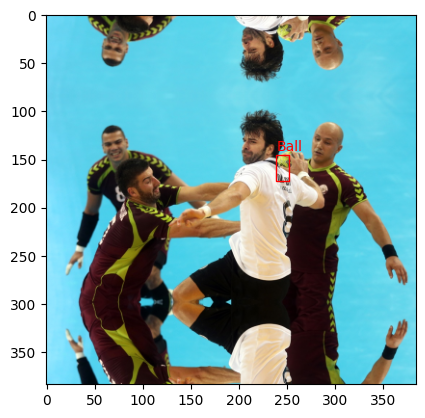

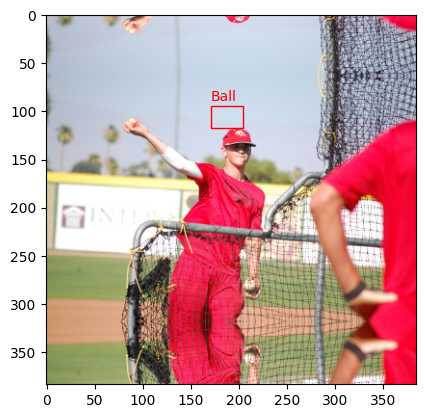

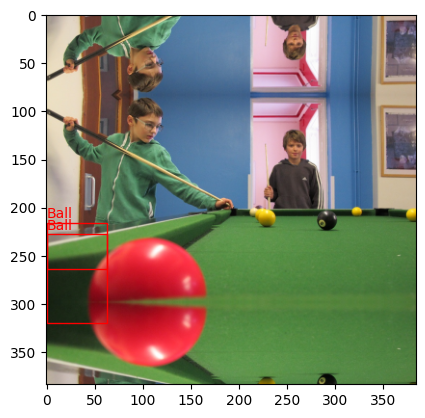

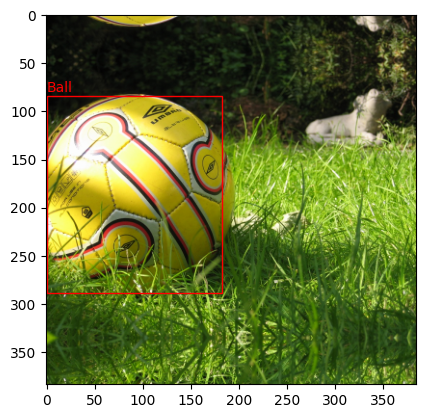

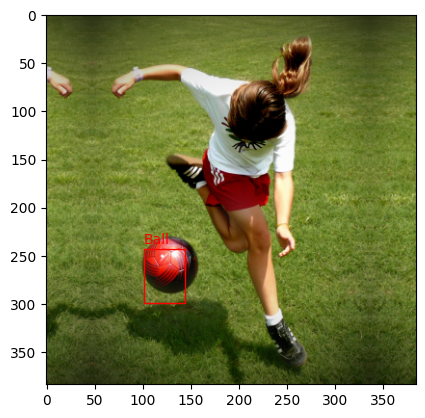

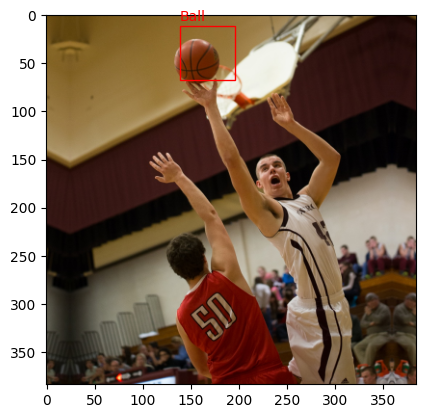

In [157]:
for i in range(len(x)):
    image, target, label = x[i].cpu(), bboxes_preds[i], labels_preds[i]

    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))

    for ann, lab in zip(target,label):
        xmin, ymin, xmax, ymax = ann
        width = xmax - xmin
        height = ymax - ymin
        class_label = LABELS[lab]

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(xmin, ymin - 5, class_label, color='r')

    plt.show()